## Jupyter notebook illustrating  commands required to use Python 2.7 modules.  Reproduces Fig 3 in Physical Review E Article:

###Motion Blur Filtering: A Statistical Approach for Extracting  Confinement Forces & Diffusivity from a Single Blurred Trajectory

#####Author: Chris Calderon

Copyright 2015 Ursa Analytics, Inc.
Licensed under the Apache License, Version 2.0 (the "License");
You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0



### Cell below loads the required modules and packages

In [1]:
%matplotlib inline 
#command above avoids using the "dreaded" pylab flag when launching ipython (always put magic command above as first arg to ipynb file)

#load some standard scientific computing and plotting modules (code tested using Python 2.7.10, Scipy 0.15.1, and Matplotlib 1.4.3)
import numpy as np
import scipy.optimize as spo
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
####################################

#finally load custom modules provided with this repo
import findBerglundVersionOfMA1 #this module builds off of Berglund's 2010 PRE parameterization (atypical MA1 formulation)
import MotionBlurFilter
import Ursa_IPyNBpltWrapper



<module 'findBerglundVersionOfMA1' from 'findBerglundVersionOfMA1.pyc'>

##Now that required modules packages are loaded, set parameters for simulating "Blurred" OU trajectories.  Specific mixed continuous/discrete model:

\begin{align}
dr_t = & ({v}-{\kappa} r_t)dt + \sqrt{2 D}dB_t \\
\psi_{t_i} = & \frac{1}{t_E}\int_{t_{i}-t_E}^{t_i} r_s ds + \epsilon^{\mathrm{loc}}_{t_i}
\end{align}

###In above equations, parameter vector specifying model is: $\theta = (\kappa,D,\sigma_{\mathrm{loc}},v)$


###Statistically exact discretization of above for uniform time spacing  $\delta$  (non-uniform $\delta$ requires time dependent vectors and matrices below):

\begin{align}
r_{t_{i+1}} = & A + F r_{t_{i}} + \eta_{t_i} \\
\psi_{t_i} = & H_A + H_Fr_{t_{i-1}} + \epsilon^{\mathrm{loc}}_{t_i} + \epsilon^{\mathrm{mblur}}_{t_i} \\
\epsilon^{\mathrm{loc}}_{t_i} + & \epsilon^{\mathrm{mblur}}_{t_i} \sim  \mathcal{N}(0,R_i) \\
\eta_i \sim & \mathcal{N}(0,Q) \\
t_{i-1} = & t_{i}-t_E \\
 C = & cov(\epsilon^{\mathrm{mblur}}_{t_i},\eta_{t_{i-1}}) \ne 0
\end{align}


####Note:  Kalman Filter (KF) and Motion Blur Filter (MBF) codes estimate $\sqrt(2D)$ directly as "thermal noise" parameter

In [2]:
#set parameters determining state dynamics 
kappa = 1. # units: [1/s]
v = 2. #units [microns/s]
D = .01 #units [microns^2/s]
twoDsqrt = np.sqrt(D*2.) #filter codes provided (KF and MBF) estimate square root of 2D directly.


#parmeters determining trajectory length, uniform spacing in time, and number of trajectories to analyze 
#(Note: code is setup up to extract MLE on trajectorywise basis [trajectories not pooled])
T = 400 #length of each trajectory
delta = 25./1000. #spacing between observations.  code can be readily modified to handle non-uniform time spacing
Ntraj = 20 #number of trajectories to simulate and obtain MLE estimate (for quick illustration, can set to 1)
#(recommended to use notebook in small simulations and plots and write "production" script from modules provided)

#set parameters determining time dependent localization noise
#to simulate constant measurement noise just set sigF=sigB
sigF=30. #final localization in nm (state assumed to be in microns)
sigB=30. #initial localization in nm (state assumed to be in microns)
    
#set parameters for time dependent localization noise (simple exponential growth)
decay = -np.log(sigB/sigF)/T

Tsub = 100 #Parameter "numerically integrating" blur integral.  Exact OU process realized in simulations below, 
#however "Tsub" parameter used to empirically simulate blur.  This is done to demonstrate that closed-form 
#"blur" expressions derived in technical report are consistent with time integrated / averaged 
#data (avoids potential self fulfilling prophecy issues).  As mentioned in paper, camera readout and other nuances
#of optical microscopy likely to manifest before this dicretization errors crops up. 
   

###Cells below simulates "blurred" trajectories based on parameters defined above.  MLE, summary statistics of parameter distribution, and sample plots reproducing figure data also shown.

In [3]:
np.random.seed(0) #set seed to allow reproducible graphs and data compared to results presented in paper
myoptmeth='nelder-mead' #set optimization for MLE search (recommended to use nelder-mead due to highly nonlinear nature of MLE)

res1=[];res2=[];res3=[]; #variables for storing MLE parameters computed over Ntraj trajectory simulations
#res1 stores directed diffusion result (obtained using modified Berglund 2010 approach adding in constant velocity)
#res2 stores the Motion Blur Filter estimates
#res3 stores the classic KF estimates

for i in range(Ntraj):
    
    #print progress bar
    print '\n','^'*100 
    print 'Iteration ', i , '  ', '&'*50 
    print '^'*100 ,'\n\n'
    
    #setup storage for noise input (used for time varying and constant localization simulations)
    locNoiseNonStat=[];locNoiseNonStatMag=[]
    
    #setup vector providing true (possibly) nonstationary noise magnitude
    for t in range(T):
        noisemag = sigF*np.exp(-decay*(T-t)) 
        locNoiseNonStatMag.append(noisemag)
        locNoiseNonStat.append(np.random.randn(1)*noisemag/1000.)
        
    locNoiseNonStat = np.array(locNoiseNonStat) #cast list for processing
    locNoiseNonStatMag =  np.array(locNoiseNonStatMag) #cast list for processing
    
    #bias the intial guess from the known simulated truth above; motion blur MLE should converge to "offset" below in large T limit
    offset = 15./1000.
    locNoiseNonStatMagGuess = (locNoiseNonStatMag/1000. - offset) #input a biased "cramer rao type" guess in microns
    pars=(kappa,twoDsqrt, offset,v)
    
###Done setting up time dependent measurement noise input and noise realization ##############
    #now simulate one trajectory of process
    xrawfull,xrawsampled,xblur   = MotionBlurFilter.simTimeIntegratedOUdeltaICvel(pars,delta,Tsub,1,T)
    #output "xrawsampled" and "xblur" above gives T samples of trajectory;  former gives exact position at t_i
    #and latter gives "motion blurred" observation (using Tsub observations and assuming uniform continuous illumination)

    print "True Pars",pars #print true data generating process (DGP) parameters

    ymeas=xblur+locNoiseNonStat #add measurement noise to "perfectly blurred" trajectory

    MA=findBerglundVersionOfMA1.CostFuncMA1Diff(ymeas,delta) #initiate instance of class object finding Berglund parameters
    #note this esimator attemps to find \theta = (sqrtD, \sigma_loca, v) [KF and MBF code attempts to find sqrt(2D) and Bergrlund
    #code provide attempts to find sqrt(D)]

    XtrueMA= np.array([pars[1]/np.sqrt(2),pars[2],pars[3]]) #set the true parameters based on the known simulation parameters
    
    #seed MA1 search with low quality estimate of truth based on true known DGP parameter (multiple truth by factor of 1/2).
    res = spo.minimize(MA.evalCostFuncVel, XtrueMA/2., method='nelder-mead',options={'xtol': 1e-5, 'disp': False})

    #store and print result
    res1.append(res.x)
    print 'MA res',res.x[0]*np.sqrt(2),res.x[1],res.x[-1]
    print '-'*100

    #use crude estimate of mean reversion parameter.  see Calderon, PRE (2013)
    kappa1 = np.log(np.sum(ymeas[1:]*ymeas[0:-1])/(np.sum(ymeas[0:-1]**2)-T*res.x[1]**2))/-delta
    
    #set initial parameter guess for filter guess 
    parsIG=np.array([np.abs(kappa1),res.x[0]*np.sqrt(2),res.x[1],res.x[-1]]) #in practice, if reliable "StaticErrorEstSeq" provided, set offset par IG to zero. 
    print 'parsIG for filters',parsIG
   
   
#   intitialize class object for filters of interest. setup code allowing for time varying noise to illustrate
#   the call sequence.  note: if optional "StaticErrorEstSeq" not defined, constant effective localization noise estimated.
    BlurF = MotionBlurFilter.ModifiedKalmanFilter1DwithCrossCorr(ymeas,delta,StaticErrorEstSeq=locNoiseNonStatMagGuess)
    KF = MotionBlurFilter.ClassicKalmanFilter(ymeas,delta,StaticErrorEstSeq=locNoiseNonStatMagGuess) #run side by side comparison of Rfixed and Rvarying
    
#   run KF MLE search (optmizatiion search for innovation MLE) with time varying or time constant noise    
    resKF = spo.minimize(KF.evalCostFunc,parsIG, method=myoptmeth)
    print 'KF result:', resKF
    res3.append(resKF.x)
    
    
    
#     parsIG2=np.array(np.hstack((np.array([resKF.x[0],res.x[0]*np.sqrt(2),.00]),resKF.x[-1])))
    parsIG2=parsIG #set initial parameter for motion blur filter 
    #(if comparing output, use same IG for both filters;  for produciton recommended to utilize KF drift pars for "warmer start")
    print 'parsIG for Motion Blur filter',parsIG2


#   run Motion Blur Filter search (optmizatiion search for innovation MLE) with time varying or time constant noise  
    resBlur = spo.minimize(BlurF.evalCostFunc,parsIG2, method=myoptmeth)
    res2.append(resBlur.x)
    print 'Motion Blur result:',resBlur
    
    
    print '*'*100
    print 'True DGP',pars
    
#   store relevant statistics and filter estimates evaluated at MLE
#   below "xfilt" corresponds to filtered state estimate 
#          "pit"  corresponds to PIT or generalized residual sequence evaluated at MLE
#          "Shist" correspond to variance of innovation sequence evaluated at MLE
#   suffix "2" after variable is used only to distinguish quantities computed with KF and MBF 
    loglike,xfilt,pit,Shist =KF.KFfilterOU1d(resKF.x) 
    loglike2,xfilt2,pit2,Shist2 =BlurF.KFfilterOU1d(resBlur.x)
    print '%'*100
    



    
    
    print 'run simple diagnostic check',np.std(pit),np.std(pit2)
    print 'correctly specied large sample PIT sequence should have std of uniform r.v. on [0,1] =',np.sqrt(1/12.)
    
#Box below outputs results of Ntraj optimizations

   


^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Iteration  0    &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ 


True Pars (1.0, 0.1414213562373095, 0.015, 2.0)
MA res 0.175907307177 0.0286451845584 0.196276811177
----------------------------------------------------------------------------------------------------
parsIG for filters [ 0.05840048  0.17590731  0.02864518  0.19627681]
KF result:   status: 0
    nfev: 259
 success: True
     fun: -1.7816118189996721
       x: array([ 0.88321288,  0.13219046,  0.01378807,  1.761304  ])
 message: 'Optimization terminated successfully.'
     nit: 150
parsIG for Motion Blur filter [ 0.05840048  0.17590731  0.02864518  0.19627681]
Motion Blur result:   status: 0
    nfev: 332
 success: True
     fun: -1.7820111214180372
       x: array([ 0.88762266,  0.13191369,  0.015036  ,  1.76942183])

In [4]:
#Summarize the results of the above Ntraj simulations (increase Ntraj to get more precise MLE par distributions)
#
#this block is useful for when one wishes to explore statistical MLE performance under different parameters and
#sampling conditions

resSUM=np.array(res2)
print 'Blur medians',np.median(resSUM[:,0]),np.median(resSUM[:,1]),np.median(resSUM[:,2]),np.median(resSUM[:,3])
print 'means',np.mean(resSUM[:,0]),np.mean(resSUM[:,1]),np.mean(resSUM[:,2]),np.mean(resSUM[:,3])
print 'std',np.std(resSUM[:,0]),np.std(resSUM[:,1]),np.std(resSUM[:,2]),np.std(resSUM[:,3])

print '^'*100 ,'\n\n'

resSUM=np.array(res3)
print 'KF medians',np.median(resSUM[:,0]),np.median(resSUM[:,1]),np.median(resSUM[:,2]),np.median(resSUM[:,3])
print 'means',np.mean(resSUM[:,0]),np.mean(resSUM[:,1]),np.mean(resSUM[:,2]),np.mean(resSUM[:,3])
print 'std',np.std(resSUM[:,0]),np.std(resSUM[:,1]),np.std(resSUM[:,2]),np.std(resSUM[:,3])

print '*'*100
print 'True DGP Parameters',pars

Blur medians 1.01607699998 0.132943219858 0.0153340832695 2.07118218241
means 1.03434743784 0.132464061743 0.0153748525719 2.08384109425
std 0.132913117729 0.0156196678532 0.00147863475233 0.238072307324
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ 


KF medians 1.00998307772 0.133494482257 0.0142935210055 2.05980130726
means 1.02707462651 0.132996029723 0.0140832244426 2.07016649811
std 0.130381692882 0.0155220233256 0.00173124482052 0.23337518562
****************************************************************************************************
True DGP Parameters (1.0, 0.1414213562373095, 0.015, 2.0)


### Now plot results shown in Technical Report Figure in Notebook Title

(1.0, 0.1414213562373095, 0.015, 2.0) [ 1.0767594   0.1637405   0.01370832  2.2075416 ]
346.410161514
MSD mean 1.52364041283


/home/calderoc/tutorial-env/lib/python2.7/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family [u'Arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


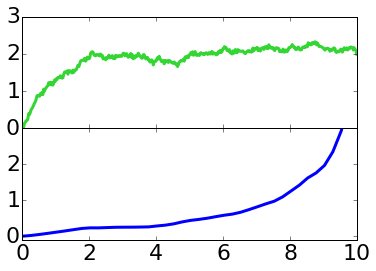

In [5]:
#setup trajectory and MSD plot in shared x-axis plot
fig,ax,axTop,pltPars = Ursa_IPyNBpltWrapper.sharedXPltSetup(axisfontsize='22',legendfontsize='18')

#setup grid for blur and fully sampled state time grid
t1=np.arange(xrawsampled.shape[0])
t1sub = np.arange(xrawfull.shape[0])/float(Tsub)
t2=(t1+.5)*delta #evaluate at midpoint as well 
t1=(t1+1)*delta #xrawsampled is at endpoint (done to keep xblur and xrawsampled same size)


ix = 0
neongreen=[51/255., 214/255., 51/255.]
axTop.plot(t2,ymeas[:,ix],'-', label='Meas. Pos.',color=neongreen,linewidth=3)
vKF=[];vB=[];vTrue=[]; #store velocity information evaluated at truth and filtered/MLE estimates
vB.append(-xfilt2*resBlur.x[0]+resBlur.x[-1])
vKF.append(-xfilt*resKF.x[0]+resKF.x[-1])
vTrue.append(-xrawsampled[:,ix]*pars[0]+pars[-1])




#tweak graph limits and appearance
axTop.yaxis.set_ticks(np.arange(0,4.,1.))

#adjust font on axis font
Ursa_IPyNBpltWrapper.xyLabels(axTop,pltPars,xlabel='',ylabel='') #adjust font style and size in main plot



#setup "time lag" grid to use in MSD computation
tlag = np.arange(1,T,10) 
tlag,MSD = findBerglundVersionOfMA1.MSD(ymeas,tlag) #evaluate MSD at tlag obs points above
tlag = tlag*delta #evalute magntidue of time lag for plotting

ax.plot(tlag,MSD,'-',linewidth=3)
print pars,resBlur.x
L = np.sqrt(6*(twoDsqrt)**2/kappa)
# ax.plot(tlag,np.ones(len(MSD))*(L**2/6.),'r--',linewidth=5,label='Exact MSD Plateau')
print L*1000


#print the MSD estimate using the last 3/4 of MSD [not unreasonable given shape, but 
#usually MSD truncation is typically quite heuristic with the "lag cutoff"; this adds additional error on top of time aggregation ]
print 'MSD mean', np.mean(np.array(MSD[25:]))

#tweak graph limits and appearance

ax.set_xlim([0,10])
ax.xaxis.set_ticks(np.arange(0,12,2))
ax.set_ylim([-.1,6.2])
ax.yaxis.set_ticks(np.arange(1,7.,2.))
ax.set_ylim([-.1,3.])
ax.yaxis.set_ticks(np.arange(0,3.,1.))

Ursa_IPyNBpltWrapper.xyLabels(ax,pltPars,xlabel='',ylabel='') #adjust font style and size in main plot (Helvetica default)

# fig.savefig('Fig3_MSDandTraj' + '.png',dpi=600)

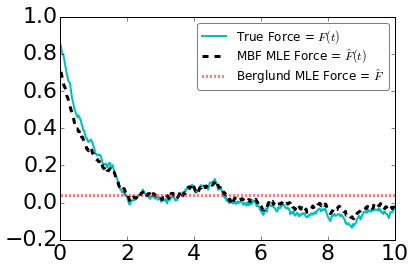

In [6]:
systemTemp = 310 #[specify Temp in Kelvin]
kT = 1.38064852e-23*1e12*1e6*systemTemp #k_B*T in units of pN*micron at specified temperature

#recall from code and note at beginnig of this document: 
#       force in MBF and KF estimates sqrt(2D), but Einstein relation assumes fric = D/kT.  rescale for this fact here.
forceScaleTrue = kT/(twoDsqrt**2)*2.
forceScaleKF = kT/(resKF.x[1]**2)*2.
forceScaleBerglund = kT/(res.x[0]**2) #this estimator estimates sqrt(D), so no factor of two needed
forceScaleBlur = kT/(resBlur.x[1]**2)*2.



fig,ax,pltPars = Ursa_IPyNBpltWrapper.basicPltSetup(axisfontsize='22') #standard plot
vNaive=(ymeas[1:]-ymeas[:-1])/delta

orange=[255/255.,153/255.,51/255.]

ax.plot(t1,np.array(vTrue[0])*forceScaleTrue,'-',linewidth=2,color='c',label='True Force = $F(t)$')
ax.plot(t1,vB[0]*forceScaleBlur,'k--',linewidth=3,label='MBF MLE Force = $\hat{F}(t)$')
ax.plot(t1,np.ones(t1.shape)*res.x[-1]*forceScaleBerglund,'r:',linewidth=3,label='Berglund MLE Force = $\hat{F}$')

#lgd = ax.legend(loc='upper right', fancybox=True, framealpha=0.5,ncol=1,numpoints=1,prop=pltPars['leg_prop'],labelspacing=.1)
#Note call above requires some OS specific tweaks.  this font adjustment has been removed, but the data displayed is identitical
lgd = ax.legend(loc='upper right', fancybox=True, framealpha=0.5,ncol=1,numpoints=1,labelspacing=.1)

Ursa_IPyNBpltWrapper.xyLabels(ax,pltPars,xlabel='',ylabel='') #adjust font style and size in main plot (Helvetica default)


#save plot
# fig.savefig('Fig3_ForceTraj' + '.png',dpi=600)

###Now plot info from example appearing in Supp. Mat.

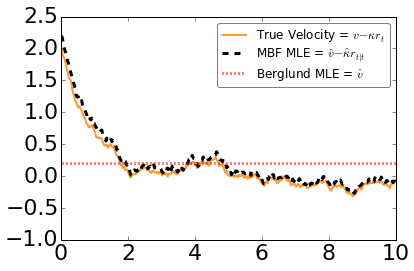

In [7]:
fig,ax,pltPars = Ursa_IPyNBpltWrapper.basicPltSetup(axisfontsize='22') #standard plot
vNaive=(ymeas[1:]-ymeas[:-1])/delta #compute the naive FD estimate

orange=[255/255.,153/255.,51/255.]
ax.plot(t1,vTrue[0],'-',linewidth=2,color=orange,label='True Velocity = $v - \kappa r_t$')
ax.plot(t1,vB[0],'k--',linewidth=3,label='MBF MLE = $\hat{v} - \hat{\kappa} r_{t|t}$')
ax.plot(t1,np.ones(t1.shape)*res.x[-1],'r:',linewidth=3,label='Berglund MLE = $\hat{v}$')


#set limits for velocity plot
ax.set_xlim([0,10])
ax.xaxis.set_ticks(np.arange(0,12,2))
ax.set_ylim([-1.,2.5])
ax.yaxis.set_ticks(np.arange(-1,3.,.5))

lgd = ax.legend(loc='upper right', fancybox=True, framealpha=0.5,ncol=1,numpoints=1,labelspacing=.1)
Ursa_IPyNBpltWrapper.xyLabels(ax,pltPars,xlabel='',ylabel='') #adjust font style and size in main plot (Helvetica default)


# ax.plot(vNaive,'-',color=grey,linewidth=.5)
# fig.savefig('Fig3_VelTraj' + '.png',dpi=600)

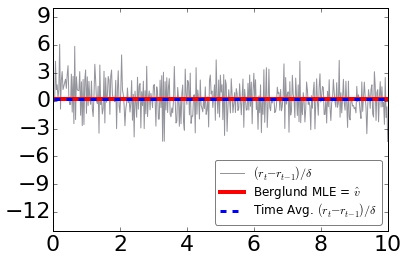

In [8]:
#now plot the finite difference estimate of velocity to show problems with attempting to take simple "time limits"
#of a nondifferentiable stochastic process (e.g., any SDE driven by Brownian motion)

fig,ax,pltPars = Ursa_IPyNBpltWrapper.basicPltSetup(axisfontsize='22') #standard plot
grey = (148/255., 148/255., 156/255.) #set custom RGB color
ax.plot(t1[1:],vNaive,'-',linewidth=1,label='$(r_{t} - r_{t-1})/\delta$',color=grey)
ax.plot(t1,np.ones(t1.shape)*res.x[-1],'r-',linewidth=4,label='Berglund MLE = $\hat{v}$')
ax.plot(t1,np.ones(t1.shape)*np.mean(vNaive),'b--',linewidth=3,label='Time Avg. $(r_{t} - r_{t-1})/\delta$')
ax.set_xlim([0,10])
ax.xaxis.set_ticks(np.arange(0,12,2))
ax.set_ylim([-14.,10])
ax.yaxis.set_ticks(np.arange(-12,12.,3))


lgd = ax.legend(loc='lower right', fancybox=True, framealpha=0.5,ncol=1,numpoints=1,labelspacing=.1)
Ursa_IPyNBpltWrapper.xyLabels(ax,pltPars,xlabel='',ylabel='') #adjust font style and size in main plot (Helvetica default)
fig.savefig('Fig3_VelFD' + '.png',dpi=600)